In [1]:
from slap import * 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('float_format', '{:.2f}'.format)
po.init_notebook_mode(connected=True)

# Table of contents
1. [The Simulacrum Datasets](#TheSimulacrumDatasets)
2. [av_tumour](#av_tumour)
3. [av_patient](#av_patient)
    1. [merge av_tumour and av_patient](#mergepatienttumour)
4. [sact_regimen](#sact_regimen)
5. [sact_tumour](#sact_tumour)
    1. [merge sact_tumour sact_regimen](#mergesact_tumoursact_regimen)
6. [sact_outcome](#sact_outcome)
    1. [merge sact_outcome and sact_regimen](#mergesact_outcomeandsact_regimen)
7. [sact_cycle](#sact_cycle)
8. [sact_patient](#sact_patient)
9. [sact_drug_detail](#sact_drug_detail)
10. [Patient pathways](#Patientpathways)

## 1.The Simulacrum Datasets <a name="TheSimulacrumDatasets"></a>
This is a table of all the columns in each dataset, there are a lot so it might be useful to see all of them in one table

**can scroll this table left/right**

In [2]:
datadict = pd.ExcelFile('Simulacrum-data-dictionary.xlsx')
sheets = datadict.sheet_names[1:]
DF = pd.DataFrame()

for sheet in sheets:
    df = pd.read_excel(datadict,sheet)
    df[sheet] = df['Field name']
    DF = pd.concat([DF,df[sheet]], axis=1)
    DF = DF.replace(np.nan, '', regex=True)
DF

,AV_PATIENT,AV_TUMOUR,SACT PATIENT,SACT TUMOUR,SACT REGIMEN,SACT OUTCOME,SACT CYCLE,SACT DRUG_DETAIL
0,PATIENTID,TUMOURID,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_OUTCOME_ID,MERGED_CYCLE_ID,MERGED_DRUG_DETAIL_ID
1,SEX,PATIENTID,LINK_NUMBER,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_REGIMEN_ID,MERGED_CYCLE_ID
2,LINKNUMBER,DIAGNOSISDATEBEST,,CONSULTANT_SPECIALITY_CODE,HEIGHT_AT_START_OF_REGIMEN,DATE_OF_FINAL_TREATMENT,CYCLE_NUMBER,ORG_CODE_OF_DRUG_PROVIDER
3,ETHNICITY,SITE_ICD10_O2,,PRIMARY_DIAGNOSIS,WEIGHT_AT_START_OF_REGIMEN,REGIMEN_MOD_DOSE_REDUCTION,START_DATE_OF_CYCLE,ACTUAL_DOSE_PER_ADMINISTRATION
4,DEATHCAUSECODE_1A,SITE_ICD10_O2_3CHAR,,MORPHOLOGY_CLEAN,INTENT_OF_TREATMENT,REGIMEN_MOD_TIME_DELAY,OPCS_PROCUREMENT_CODE,OPCS_DELIVERY_CODE
5,DEATHCAUSECODE_1B,MORPH_ICD10_O2,,,DATE_DECISION_TO_TREAT,REGIMEN_MOD_STOPPED_EARLY,PERF_STATUS_START_OF_CYCLE,ADMINISTRATION_ROUTE
6,DEATHCAUSECODE_1C,BEHAVIOUR_ICD10_O2,,,START_DATE_OF_REGIMEN,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,ADMINISTRATION_DATE
7,DEATHCAUSECODE_2,T_BEST,,,MAPPED_REGIMEN,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,DRUG_GROUP
8,DEATHCAUSECODE_UNDERLYING,N_BEST,,,CLINICAL_TRIAL,MERGED_TUMOUR_ID,,MERGED_PATIENT_ID
9,DEATHLOCATIONCODE,M_BEST,,,CHEMO_RADIATION,,,MERGED_TUMOUR_ID


Diagram of how the datasets are linked:

<img src="docs/tablestructure.jpeg" alt="ts" width="500"/>

The data can be downloaded from https://simulacrum.healthdatainsight.org.uk/requesting-data/

Now load in the datasets as pandas dataframes:

In [3]:
%%time

#directory of the data
dir_data = "../simulacrum_release_v1.1.0"

#add_descriptions=True adds columns of descriptions to the codes
df_av_tumour = load.load_table('av_tumour', add_descriptions=True, folder=dir_data)
df_av_patient = load.load_table('av_patient', add_descriptions=True, folder=dir_data)
df_sact_regimen = load.load_table('sact_regimen', add_descriptions=True, folder=dir_data)
df_sact_tumour = load.load_table('sact_tumour', add_descriptions=True, folder=dir_data)
df_sact_outcome = load.load_table('sact_outcome', add_descriptions=True, folder=dir_data)
df_sact_patient = load.load_table('sact_patient',add_descriptions=True, folder=dir_data)
df_sact_cycle = load.load_table('sact_cycle',add_descriptions=True, folder=dir_data)
df_drug_detail = load.load_table('sact_drug_detail',add_descriptions=True, folder=dir_data)

CPU times: user 47.3 s, sys: 2.4 s, total: 49.7 s
Wall time: 45 s


## 2. av_tumour <a name="av_tumour"></a>

In [4]:
display(df_av_tumour.head())

print("there are ",df_av_tumour.shape[0]," diagnosed tumours")

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,SITE_ICD10_O2_DESC,SITE_ICD10_O2_3CHAR_DESC,MORPH_ICD10_O2_DESC,BEHAVIOUR_ICD10_O2_DESC,STAGE_BEST_DESC,GRADE_DESC,SEX_DESC,CREG_CODE_DESC,ER_STATUS_DESC,PR_STATUS_DESC,HER2_STATUS_DESC,CANCERCAREPLANINTENT_DESC,PERFORMANCESTATUS_DESC,CNS_DESC,ACE27_DESC,LATERALITY_DESC,HISTOLOGY_DESC
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,90.00,2,L0801,810000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06,L,3,Skin of other and unspecified parts of face,Other malignant neoplasms of skin,Basal cell tumour/Basal cell carcinoma,MALIGNANT,INSUFFICIENT INFO,X,FEMALE,Oxford Cancer Intelligence Unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEFT,BASAL CELL CARCINOMA NOS
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,84.00,2,L0301,810000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-06,8,2,"Malignant neoplasm of skin, unspecified",Other malignant neoplasms of skin,Basal cell tumour/Basal cell carcinoma,MALIGNANT,INSUFFICIENT INFO,X,FEMALE,North West Cancer Intelligence Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,68.00,1,L0401,810000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,8,1 - least deprived,"Malignant neoplasm of skin, unspecified",Other malignant neoplasms of skin,Basal cell tumour/Basal cell carcinoma,MALIGNANT,INSUFFICIENT INFO,X,MALE,Northern & Yorkshire Cancer Registry & Informa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,69.00,1,L1001,810000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,8,2,"Malignant neoplasm of skin, unspecified",Other malignant neoplasms of skin,Basal cell tumour/Basal cell carcinoma,MALIGNANT,INSUFFICIENT INFO,X,MALE,Thames Cancer Registry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,U,NaN,GX,58.00,2,L0401,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-01,8,2,"Malignant neoplasm of skin, unspecified",Other malignant neoplasms of skin,Basal cell tumour/Basal cell carcinoma,MALIGNANT,UNSTAGEABLE,X,FEMALE,Northern & Yorkshire Cancer Registry & Informa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS


there are  1402817  diagnosed tumours


Unique diagnosis years:

In [5]:
df_av_tumour["DIAGNOSISDATEBEST"].apply(lambda x: x.year).unique()

array([2015, 2013, 2014])

We would like to make some comparisons to real data to see how accurate the datasets are. 

Starting with the top 20 diagnosed tumours:

In [6]:
df_av_tumour['SITE_ICD10_O2_3CHAR_DESC'].value_counts()[:20]

Other malignant neoplasms of skin                       350130
Malignant neoplasm of breast                            133907
Malignant neoplasm of prostate                          119347
Malignant neoplasm of bronchus and lung                 102350
Carcinoma in situ of cervix uteri                        76678
Malignant neoplasm of colon                              65825
Malignant melanoma of skin                               38155
Malignant neoplasm of rectum                             27163
Malignant neoplasm of kidney, except renal pelvis        26195
Carcinoma in situ of other and unspecified sites         25193
Malignant neoplasm of bladder                            24643
Malignant neoplasm of corpus uteri                       21849
Malignant neoplasm of pancreas                           21344
Malignant neoplasm of oesophagus                         20996
Carcinoma in situ of breast                              19777
Diffuse non-Hodgkin's lymphoma                         

Can compare this with [cancer research uk](https://www.cancerresearchuk.org/health-professional/cancer-statistics/incidence/common-cancers-compared#heading-Zero). We have the top diagnosed cancer as skin cancer which doesn't agree with cancer research uk, this might be due to single patients having multiple melanomas of skin. 

What are the distributions of these cancers along age?

In [7]:
stacked_barplot(df_av_tumour, 'SITE_ICD10_O2_3CHAR', 'AGE')

The colours on this graph correspond to tumour site and the legend is showing the icd10 codes of those tumour sites. This is plotted with plotly, **you can remove a specific tumour by clicking on it's icd10 code in the legend once, and double clicking will isolate it.**

We can compare this graph with a graph from [cancer research uk](https://www.cancerresearchuk.org/health-professional/cancer-statistics/incidence/age#heading-Zero)

The distribution is similar except the peak at around 25 years due to D06, you can convert D06 into actual words:

In [8]:
descriptions.get_descriptions('D06', 'icd')[0]

'CARCINOMA-IN-SITU OF CERVIX UTERI'

The peak is due to cervical cancer which is also apparent in this graph from [cancer research uk](https://www.cancerresearchuk.org/health-professional/cancer-statistics/statistics-by-cancer-type/cervical-cancer/incidence#heading-One)

<br/>
<br/>

Can also plot other columns of av_tumour, for example behaviour:

In [9]:
for i in range(10):
    print(i,descriptions.get_descriptions(str(i),'behaviour')[0])
    
stacked_barplot(df_av_tumour, 'SITE_ICD10_O2_3CHAR', 'BEHAVIOUR_ICD10_O2',tickmode='linear')

0 BENIGN
1 UNCERTAIN
2 IN SITU
3 MALIGNANT
4 nan
5 MICRO-INVASIVE
6 MALIGNANT, METASTATIC/ SECONDARY SITE
7 nan
8 nan
9 MALIGNANT, UNCERTAIN WHETHER PRIMARY OR METASTATIC


### Errors in av_tumour

The column `SITE_ICD10_O2_3CHAR` is meant to be identical to `SITE_ICD10_O2` but instead only having 3 characters, this is not the case for all tumours. Examples of such errors are shown in the data frame below. 

In [10]:
incorrect = df_av_tumour['SITE_ICD10_O2'].apply(lambda s: str(s)[0:3]) \
            != df_av_tumour['SITE_ICD10_O2_3CHAR']

print(incorrect.value_counts()[1],"erroneous entries. ")
display(df_av_tumour[incorrect].tail(3))


54161 erroneous entries. 


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,SITE_ICD10_O2_DESC,SITE_ICD10_O2_3CHAR_DESC,MORPH_ICD10_O2_DESC,BEHAVIOUR_ICD10_O2_DESC,STAGE_BEST_DESC,GRADE_DESC,SEX_DESC,CREG_CODE_DESC,ER_STATUS_DESC,PR_STATUS_DESC,HER2_STATUS_DESC,CANCERCAREPLANINTENT_DESC,PERFORMANCESTATUS_DESC,CNS_DESC,ACE27_DESC,LATERALITY_DESC,HISTOLOGY_DESC
1402814,220052225,220045122,2015-01-30,D075,D01,8140,2,NaN,NaN,NaN,0,22,GX,66.00,1,L0801,1020045122,NaN,NaN,NaN,NaN,NaN,NaN,C,0,99,NaN,NaN,NaN,NaN,NaN,2015-02-07,8,2,Prostate,Carcinoma in situ of other and unspecified dig...,Adenoma/Bronchial adenoma/Adenocarcinoma,IN SITU,0,X,MALE,Oxford Cancer Intelligence Unit,NaN,NaN,NaN,Curative,Able to carry out all normal activity without ...,NaN,NaN,NOT APPLICABLE,ADENOCARCINOMA IN SITU
1402815,220052228,220010521,2015-11-02,C051,C61,8000,3,NaN,2,1,4,22,GX,61.00,1,L1701,1020010521,NaN,NaN,NaN,NaN,NaN,NaN,Z,2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,8,5 - most deprived,Soft palate,Malignant neoplasm of prostate,Neoplasm,MALIGNANT,4,X,MALE,West Midlands Cancer Intelligence Unit,NaN,NaN,NaN,Non Curative,"Able to walk and capable of all self care, but...",NaN,NaN,NOT APPLICABLE,NEOPLASM MALIGNANT
1402816,220052229,220014422,2015-10-27,C441,C64,8046,3,2a,2,1,4,20,GX,57.00,1,L0201,1020014422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,L,5 - most deprived,"Skin of eyelid, including canthus","Malignant neoplasm of kidney, except renal pelvis",NaN,MALIGNANT,4,X,MALE,Eastern Cancer Registration & Information Centre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEFT,NON SMALL CELL CARCINOMA OF LUNG


## 3. av_patient <a name="av_patient"></a>

In [11]:
display(df_av_patient.head())
print("there are ", len(df_av_patient), " patients")

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE,SEX_DESC,ETHNICITY_DESC,DEATHLOCATIONCODE_DESC,DEATHCAUSECODE_1A_DESC,DEATHCAUSECODE_1B_DESC,DEATHCAUSECODE_1C_DESC,DEATHCAUSECODE_2_DESC,DEATHCAUSECODE_UNDERLYING_DESC,NEWVITALSTATUS_DESC
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17,FEMALE,WHITE BRITISH,NaN,,,,,,Alive
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14,FEMALE,NOT STATED,NaN,,,,,,Alive
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17,MALE,WHITE BRITISH,NaN,,,,,,Alive
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13,MALE,WHITE BRITISH,NaN,,,,,,Alive
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,FEMALE,NaN,NaN,,,,,,Alive


there are  1322100  patients


Which years are the data from?

In [12]:
vital_status_years = df_av_patient['VITALSTATUSDATE'].apply(lambda x: x.year)

print(vital_status_years.unique())

[2017 2016 2015 2013 2014 1900]


The year 1900 appears to be an error but there are only 31 patients with this.

In [13]:
(vital_status_years == 1900).sum()

31

Frequency of the top 20 death causes:

In [14]:
#group by sex and count the type of deaths

useable_groupings = ['DEATHCAUSECODE_UNDERLYING_DESC', 'ETHNICITY_DESC',
                     'DEATHLOCATIONCODE_DESC',]

av_patient_frequency(df_av_patient, useable_groupings[0], 20)

You can compare this graph with:

https://www.cancerresearchuk.org/health-professional/cancer-statistics/mortality/common-cancers-compared#heading-Zero

Which is from 2015

### Quantum patients
There are a number of entries that can be described as 'schrodinger's patients' who are both dead and alive at the same time. These quantum patients have either erroneously been generated by the simulacrum algorithm, or they are common errors in the real life data taking procedure and the simulacrum has succesfully simulated that. 

patients with a non null deathcause `"DEATHCAUSECODE_UNDERLYING"` and a dead vital status `"NEWVITALSTATUS" != "D"`:

In [15]:
dead_alive = df_av_patient[(df_av_patient["DEATHCAUSECODE_UNDERLYING"].notnull()) \
                        & (df_av_patient["NEWVITALSTATUS"] != "D")]

print("There are",len(dead_alive),"such quantum patients")

There are 179511 such quantum patients


## 3.A. merge av_tumour and av_patient <a name="mergepatienttumour"></a>

In [16]:
df_tumour_patient = pd.merge(df_av_tumour,df_av_patient,on='PATIENTID')
print(df_av_tumour.shape,df_av_patient.shape,df_tumour_patient.shape) 

(1402817, 51) (1322100, 21) (1402817, 71)


create column with days between date of vital status taken and date of diagnosis

In [17]:
df_tumour_patient['VITAL - DIAGNOSIS (days)'] = df_tumour_patient['VITALSTATUSDATE'] - df_tumour_patient['DIAGNOSISDATEBEST']
df_tumour_patient['VITAL - DIAGNOSIS (days)'] = [i.days for i in df_tumour_patient['VITAL - DIAGNOSIS (days)']]
df_tumour_patient = df_tumour_patient[df_tumour_patient['VITAL - DIAGNOSIS (days)'] >= 0] #some have vital status in 1900

print("stats for the number of days from diagnosis to new vital status taken.")
df_tumour_patient['VITAL - DIAGNOSIS (days)'].describe()


stats for the number of days from diagnosis to new vital status taken.


count   1402784.00
mean        767.48
std         407.92
min           0.00
25%         466.00
50%         769.00
75%        1105.00
max        1484.00
Name: VITAL - DIAGNOSIS (days), dtype: float64

## 4. sact_regimen <a name="sact_regimen"></a>

https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python - loading sim_sact_regimen

there are multiple regimens for some tumours

In [18]:
print(df_sact_regimen.shape)
display(df_sact_regimen.head())

(471919, 14)


,MERGED_REGIMEN_ID,MERGED_TUMOUR_ID,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID,BENCHMARK_GROUP,INTENT_OF_TREATMENT_DESC,CLINICAL_TRIAL_DESC
0,10000001,10000001,-1.00,nan,N,2015-03-08,2015-03-08,DEGARELIX,NaN,N,10000235,HORMONES,Neoadjuvant,NaN
1,10000002,10000002,nan,nan,P,2016-07-09,2016-07-10,BICALUTAMIDE + GOSERELIN,NaN,N,10000315,HORMONES,Palliative,NaN
2,10000003,10000003,nan,nan,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES,Palliative,NO
3,10000004,10000004,nan,nan,NaN,2015-03-17,2015-03-23,Rituximab,N,NaN,10000480,RITUXIMAB,NaN,NO
4,10000005,10000005,0.00,nan,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE,Curative,NO


unique years of start of regimen

In [19]:
df_sact_regimen['START_DATE_OF_REGIMEN'].apply(lambda x: x.year).value_counts()

2015    151925
2014    140413
2013     98720
2016     65213
2017      9523
2012      3032
2011      1502
2010       686
2018       463
2009       178
2008        83
1941        47
2007        31
2006        17
2019        14
2003        13
1942        13
2005         9
2002         7
1900         5
1975         4
1860         4
2000         4
1998         3
1944         3
1999         2
1986         1
1974         1
1934         1
2001         1
2004         1
Name: START_DATE_OF_REGIMEN, dtype: int64

The Simulacrum imitates data about tumours diagnosed in England in 2013, 2014, and 2015. : https://simulacrum.healthdatainsight.org.uk/available-data

dates below these are either errors in the simulation, or errors in real life that has been simulated correctly


## 5. sact_tumour <a name="sact_tumour"></a>

tumours that have received systemic anti-cancer therapy

In [20]:
df_sact_tumour.head()

,MERGED_TUMOUR_ID,MERGED_PATIENT_ID,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,CONSULTANT_SPECIALITY_CODE_DESC,PRIMARY_DIAGNOSIS_DESC,MORPHOLOGY_CLEAN_DESC
0,10000001,10000235,101,C61,81403,UROLOGY,Malignant neoplasm of prostate,ADENOCARCINOMA NOS
1,10000002,10000315,101,C679,81403,UROLOGY,"Bladder, unspecified",ADENOCARCINOMA NOS
2,10000003,10000337,100,C500,NaN,GENERAL SURGERY,Nipple and areola,NaN
3,10000004,10000480,303,C829,NaN,CLINICAL HAEMATOLOGY,"Follicular non-Hodgkin's lymphoma, unspecified",NaN
4,10000005,10000533,823,D473,NaN,HAEMATOLOGY,Essential (haemorrhagic) thrombocythaemia,NaN


### 5.1 merge sact_tumour sact_regimen

In [21]:
df_tumour_regimen = pd.merge(df_sact_tumour,df_sact_regimen,on='MERGED_TUMOUR_ID')
print('df_sact_tumour.shape ',df_sact_tumour.shape)
print('df_sact_regimen.shape ',df_sact_regimen.shape)
print('df_tumour_regimen.shape ',df_tumour_regimen.shape) 

df_sact_tumour.shape  (299727, 8)
df_sact_regimen.shape  (471919, 14)
df_tumour_regimen.shape  (471919, 21)


In [22]:
df_tumour_regimen.head()

,MERGED_TUMOUR_ID,MERGED_PATIENT_ID_x,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,CONSULTANT_SPECIALITY_CODE_DESC,PRIMARY_DIAGNOSIS_DESC,MORPHOLOGY_CLEAN_DESC,MERGED_REGIMEN_ID,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_y,BENCHMARK_GROUP,INTENT_OF_TREATMENT_DESC,CLINICAL_TRIAL_DESC
0,10000001,10000235,101,C61,81403,UROLOGY,Malignant neoplasm of prostate,ADENOCARCINOMA NOS,10000001,-1.00,nan,N,2015-03-08,2015-03-08,DEGARELIX,NaN,N,10000235,HORMONES,Neoadjuvant,NaN
1,10000002,10000315,101,C679,81403,UROLOGY,"Bladder, unspecified",ADENOCARCINOMA NOS,10000002,nan,nan,P,2016-07-09,2016-07-10,BICALUTAMIDE + GOSERELIN,NaN,N,10000315,HORMONES,Palliative,NaN
2,10000003,10000337,100,C500,NaN,GENERAL SURGERY,Nipple and areola,NaN,10000003,nan,nan,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES,Palliative,NO
3,10000004,10000480,303,C829,NaN,CLINICAL HAEMATOLOGY,"Follicular non-Hodgkin's lymphoma, unspecified",NaN,10000004,nan,nan,NaN,2015-03-17,2015-03-23,Rituximab,N,NaN,10000480,RITUXIMAB,NaN,NO
4,10000005,10000533,823,D473,NaN,HAEMATOLOGY,Essential (haemorrhagic) thrombocythaemia,NaN,10000005,0.00,nan,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE,Curative,NO


Given a primary diagnosis, what are the the regimens given to that diagnosis?

In [23]:
#only include top20 benchmark group and top30 primary diagnosis in tumour_regimen
#this is beccause there are 809 different benchmarks and 700 different diagnosis

top20bench = df_tumour_regimen['BENCHMARK_GROUP'].value_counts()[:20].keys()
top30diag = df_tumour_regimen['PRIMARY_DIAGNOSIS'].value_counts()[:30].keys()

topbenchdiag = df_tumour_regimen.loc[(df_tumour_regimen['BENCHMARK_GROUP'].isin(top20bench)) & 
                                  (df_tumour_regimen['PRIMARY_DIAGNOSIS'].isin(top30diag))]

In [24]:
stacked_barplot(topbenchdiag,'BENCHMARK_GROUP', 'PRIMARY_DIAGNOSIS')

This is a frequency plot of primary diagnosis of patients with the different colours as the BENCHMARK_GROUP(type of regimen i think) given to that patient.

this only shows the top 30 PRIMARY_DIAGNOSIS and top 30 BENCHMARK_GROUP

## 6. sact_outcome <a name="sact_outcome"></a>

In [25]:
df_sact_outcome.head()

,MERGED_OUTCOME_ID,MERGED_REGIMEN_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,REGIMEN_OUTCOME_SUMMARY_DESC
0,10000001,10000003,2014-01-09,N,N,N,NaN,10000337,10000003,NaN
1,10000002,10000005,nan,Y,Y,N,NaN,10000533,10000005,NaN
2,10000003,10000006,nan,N,Y,N,NaN,10000697,10000006,NaN
3,10000004,10000007,nan,Y,NaN,N,NaN,10000697,10000006,NaN
4,10000005,10000008,2012-12-07,NaN,NaN,NaN,NaN,10000773,10009036,NaN


In [26]:
df_sact_outcome.shape

(351668, 10)

unique years of date of final treatment

In [27]:
df_sact_outcome['DATE_OF_FINAL_TREATMENT'].apply(lambda x: x[:4]).value_counts()

nan     175257
2015     56402
2014     50818
2016     31392
2013     30397
2017      5406
2012       936
2011       466
2018       275
2010       179
2009        52
2008        19
2019        12
1941        12
1942        10
2007         9
2006         5
2002         4
2003         3
1999         2
1860         2
1944         2
2005         2
1934         1
2004         1
1861         1
1959         1
1900         1
7626         1
Name: DATE_OF_FINAL_TREATMENT, dtype: int64

Again, some of these dates are errors in the simulation, or errors in real life that has been simulated correctly

## 6.A merge sact_outcome and sact_regimen <a name="mergesact_outcomeandsact_regimen"></a>

In [28]:
df_outcome_regimen = pd.merge(df_sact_regimen,df_sact_outcome,on='MERGED_REGIMEN_ID')

print('df_sact_outcome.shape',df_sact_outcome.shape)
print('df_sact_regimen.shape',df_sact_regimen.shape)
print('df_outcome_regimen.shape',df_outcome_regimen.shape) 

df_sact_outcome.shape (351668, 10)
df_sact_regimen.shape (471919, 14)
df_outcome_regimen.shape (351668, 23)


In [29]:
df_outcome_regimen.head()

,MERGED_REGIMEN_ID,MERGED_TUMOUR_ID_x,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_x,BENCHMARK_GROUP,INTENT_OF_TREATMENT_DESC,CLINICAL_TRIAL_DESC,MERGED_OUTCOME_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID_y,MERGED_TUMOUR_ID_y,REGIMEN_OUTCOME_SUMMARY_DESC
0,10000003,10000003,nan,nan,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES,Palliative,NO,10000001,2014-01-09,N,N,N,NaN,10000337,10000003,NaN
1,10000005,10000005,0.00,nan,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE,Curative,NO,10000002,nan,Y,Y,N,NaN,10000533,10000005,NaN
2,10000006,10000006,1.78,nan,C,2011-07-23,2012-05-14,CHOP R - 21 days,N,N,10000697,CHOP R,Curative,NO,10000003,nan,N,Y,N,NaN,10000697,10000006,NaN
3,10000007,10000006,1.75,58.50,D,2014-07-24,2014-07-25,Rituximab,N,NaN,10000697,RITUXIMAB,Disease Modification,NO,10000004,nan,Y,NaN,N,NaN,10000697,10000006,NaN
4,10000008,10009036,nan,78.00,C,2012-12-07,2012-12-07,LEUPRORELIN,99,N,10000773,HORMONES,Curative,NaN,10000005,2012-12-07,NaN,NaN,NaN,NaN,10000773,10009036,NaN


What are the outcomes of each regimen?

In [30]:
#only include top 20 bench
top20bench = df_outcome_regimen['BENCHMARK_GROUP'].value_counts()[:20].keys()

df_top_outcome_regimen = df_outcome_regimen.loc[df_outcome_regimen['BENCHMARK_GROUP'].isin(top20bench)]

stacked_barplot(df_top_outcome_regimen,'BENCHMARK_GROUP', 'REGIMEN_OUTCOME_SUMMARY', tickmode='linear')

This is a frequency plot of REGIMEN_OUTCOME_SUMMARY with the different colours as the BENCHMARK_GROUP (type of regimen think)

What the numbers mean:

In [31]:
for i in range(10):
    print(i,descriptions.get_descriptions(str(i),'regimenoutcome')[0])


0 Treatment completed as prescribed
1 PATIENT died
2 Progressive disease during Chemotherapy
3 Acute Chemotherapy toxicity
4 Technical or organisational problems
5 PATIENT choice (stopped or interrupted treatment)
6 nan
7 nan
8 nan
9 Not Known


## 7. sact_cycle <a name="sact_cycle"></a>

In [32]:
display(df_sact_cycle.head())

print('shape ',df_sact_cycle.shape)

,MERGED_CYCLE_ID,MERGED_REGIMEN_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,PERF_STATUS_START_OF_CYCLE_DESC
0,10000001,10000001,4,2015-06-07,NaN,NaN,10000235,10000001,NaN
1,10000002,10000002,2,2016-08-07,NaN,00,10000315,10000002,"100% = Fully active, normal"
2,10000003,10000003,3,NaT,X715,NaN,10000337,10000003,NaN
3,10000004,10000004,2,2015-03-23,X712,0,10000480,10000004,Able to carry out all normal activity without ...
4,10000005,10000005,1,2013-03-11,X711,NaN,10000533,10000005,NaN


shape  (1462099, 9)


unique years of start date cycle

In [33]:
df_sact_cycle['START_DATE_OF_CYCLE'].apply(lambda x: x.year).value_counts()

2015.00    401072
2014.00    364814
2016.00    224550
2013.00    211804
2017.00     40700
2012.00      6989
2011.00      3368
2018.00      3015
2010.00      1529
2009.00       410
2008.00       176
2019.00       120
1900.00        97
1941.00        88
2007.00        81
2006.00        47
1942.00        40
2005.00        40
2003.00        19
1999.00        16
2000.00        14
2002.00        13
1976.00        11
1860.00        11
1944.00         8
2004.00         7
2001.00         6
1998.00         6
1966.00         5
1975.00         5
2020.00         4
1961.00         3
1986.00         2
1934.00         2
1861.00         2
1960.00         1
1974.00         1
1943.00         1
Name: START_DATE_OF_CYCLE, dtype: int64

## 8. sact_patient <a name="sact_patient"></a>

In [34]:
display(df_sact_patient.head())

print('shape ',df_sact_patient.shape)

,MERGED_PATIENT_ID,LINK_NUMBER
0,10000087,810000087
1,10000235,810000235
2,10000283,810000283
3,10000315,810000315
4,10000337,810000337


shape  (245938, 2)


## 9. sact_drug_detail <a name="sact_drug_detail"></a>

In [35]:
display(df_drug_detail.head())

,MERGED_DRUG_DETAIL_ID,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,ADMINISTRATION_ROUTE_DESC
0,10000001,10000001,EKD02,10.00,NaN,1,2015-06-07,STEROID,10000235,10000001,10000001,Intravenous
1,10000002,10000002,EGU02,30.00,NaN,2,NaT,NOT CHEMO,10000315,10000002,10000002,Oral
2,10000003,10000003,EGU05,1000.00,NaN,1,NaT,RITUXIMAB,10000337,10000003,10000003,Intravenous
3,10000004,10000004,EXO,8.00,X723,2,2015-03-23,NOT CHEMO,10000480,10000004,10000004,Oral
4,10000005,10000005,ETD02,1000.00,NaN,2,2013-03-11,NOT CHEMO,10000533,10000005,10000005,Oral


unique years of admin dates

In [36]:
df_drug_detail['ADMINISTRATION_DATE'].apply(lambda x: x.year).value_counts()

2015.00    956813
2014.00    875993
2013.00    520883
2016.00    516628
2017.00     90468
2012.00     16014
2011.00      7593
2018.00      6509
2010.00      3688
2009.00      1009
2008.00       424
2019.00       225
1941.00       222
2007.00       208
1900.00       182
2006.00       112
2005.00       106
1942.00        99
2003.00        45
2002.00        27
1860.00        26
2001.00        24
2004.00        22
2000.00        21
1976.00        19
1999.00        18
1944.00        18
1998.00        13
1961.00        13
1975.00        11
1966.00         7
1934.00         7
1943.00         7
2020.00         6
1986.00         4
1974.00         3
1861.00         3
1960.00         3
1962.00         1
Name: ADMINISTRATION_DATE, dtype: int64

In [37]:
drugs = df_drug_detail['DRUG_GROUP'].unique()
sorted(drugs)[75:100]

['EXEMESTANE',
 'FILGRASTIM',
 'FLUCONAZOLE',
 'FLUDARABINE',
 'FLUOROURACIL',
 'FOLINIC ACID',
 'FULVESTRANT',
 'GANETESPIB',
 'GEFETINIB',
 'GEFITINIB',
 'GEMCITABINE',
 'GEMTUZUMAB',
 'GEMTUZUMAB OZOGAMICIN',
 'GEMTUZUMAB OZOGAMYCIN',
 'GONADORELIN',
 'GOSERELIN',
 'HERCEPTIN',
 'HYDROCORTISONE',
 'HYDROXYCARBAMIDE',
 'HYDROXYCARBIMIDE',
 'IBANDRONATE',
 'IBRITINIB',
 'IBRUTANIB',
 'IBRUTINIB',
 'IDARUBICIN']

there are some repeated drugs due to spelling mistakes e.g.  'GEMTUZUMAB OZOGAMICIN' 'GEMTUZUMAB OZOGAMYCIN'

A basic fix to these spelling mistakes is to use a sequence similarity measure:

In [38]:
from difflib import SequenceMatcher

def similar(a, b):
    """returns a similarity measure in [0,1]
    between two strings a, b"""
    return SequenceMatcher(None, a, b).ratio()


#examples
for spelling1, spelling2 in zip(['IBRITINIB', 'GEMTUZUMAB OZOGAMICIN', 'FLUCONAZOLE', 'MASITINIB'],
                                ['IBRUTANIB', 'GEMTUZUMAB OZOGAMYCIN', 'FLUOROURACIL', 'AXITINIB']):
    print(similar(spelling1,spelling2), spelling1 + ", " + spelling2)



0.7777777777777778 IBRITINIB, IBRUTANIB
0.9523809523809523 GEMTUZUMAB OZOGAMICIN, GEMTUZUMAB OZOGAMYCIN
0.43478260869565216 FLUCONAZOLE, FLUOROURACIL
0.8235294117647058 MASITINIB, AXITINIB


The problem here is `MASITINIB,AXITINIB` are similar but not the same drug.

To fix this we can split the word into three and calculate the similarities between the first/second parts:

In [39]:
def similar2(a, b):
    """returns similarity measures in [0,1]
    between the first and second half 
    of strings a, b"""
    
    len_a = int(len(a)/2)
    len_b = int(len(b)/2)
    first_half = SequenceMatcher(None, a[:len_a], b[:len_b]).ratio()
    second_half = SequenceMatcher(None, a[len_a:], b[len_b:]).ratio()
    
    return first_half, second_half

#same examplesthird
for spelling1, spelling2 in zip(['IBRITINIB', 'GEMTUZUMAB OZOGAMICIN', 'FLUCONAZOLE', 'MASITINIB'],
                                ['IBRUTANIB', 'GEMTUZUMAB OZOGAMYCIN', 'FLUOROURACIL', 'AXITINIB']):
    print(similar2(spelling1,spelling2), spelling1 + "," + spelling2)

(0.75, 0.8) IBRITINIB,IBRUTANIB
(1.0, 0.9090909090909091) GEMTUZUMAB OZOGAMICIN,GEMTUZUMAB OZOGAMYCIN
(0.7272727272727273, 0.3333333333333333) FLUCONAZOLE,FLUOROURACIL
(0.5, 0.8888888888888888) MASITINIB,AXITINIB


now choose a threshold such that both the first and second half of each spelling are similar. This will decide if it's they are spelling mistakes of the same drug.

The identified spelling mistakes are:

In [40]:
threshold = 0.7
spelling_mistakes = []

for spelling1 in drugs:
    
    similar_spelling1 = [spelling1]
    
    for spelling2 in drugs:
        
        if (all(np.array(similar2(spelling1,spelling2))>0.7) and  spelling1 != spelling2):
            
            similar_spelling1.append(spelling2)
    
    if len(similar_spelling1) != 1:
        print(similar_spelling1)
    spelling_mistakes.append(similar_spelling1)
    
spelling_mistakes = list(set([tuple(sorted(s_m)) for s_m in spelling_mistakes]))

['OCTRETOTIDE', 'OCTREOTIDE']
['MITOMYCIN', 'MYTOMYCIN']
['IDELALISIB', 'IDEALISIB']
['IBRUTINIB', 'IBRUTANIB', 'IBRITINIB']
['GEFITINIB', 'GEFETINIB']
['BICALUTAMIDE', 'BICALULTAMIDE']
['HYDROXYCARBAMIDE', 'HYDROXYCARBIMIDE']
['LIPOSOMAL DOXORUBICIN', 'LIPOSOMAL DAUNORUBICIN']
['ELOTUZUMAB', 'VELTUZUMAB']
['NINTEDANIB', 'NINTENDINIB']
['LIPOSOMAL DOXORUBICIN (CAELYX)', 'LIPOSOMAL DOXORUBICIN (MYOCET)']
['GEMTUZUMAB OZOGAMYCIN', 'GEMTUZUMAB OZOGAMICIN']
['BICALULTAMIDE', 'BICALUTAMIDE']
['NINTENDINIB', 'NINTEDANIB']
['GEFETINIB', 'GEFITINIB']
['MYTOMYCIN', 'MITOMYCIN']
['IBRUTANIB', 'IBRUTINIB', 'IBRITINIB']
['VELTUZUMAB', 'ELOTUZUMAB']
['IDEALISIB', 'IDELALISIB']
['GEMTUZUMAB OZOGAMICIN', 'GEMTUZUMAB OZOGAMYCIN']
['IBRITINIB', 'IBRUTINIB', 'IBRUTANIB']
['LIPOSOMAL DAUNORUBICIN', 'LIPOSOMAL DOXORUBICIN']
['HYDROXYCARBIMIDE', 'HYDROXYCARBAMIDE']
['OCTREOTIDE', 'OCTRETOTIDE']


There are two misidentified spelling mistake, this algorithm can be improved more in detail but it will not be important as there are only about 0.3\% spelling mistakes

now to replace the drugs with a single spelling:

In [41]:
#create a map from multiple spelling to single spelling:

#all 
single_spelling = {}
for s_m in spelling_mistakes:
    for s in s_m:
        single_spelling[s]=s_m[0]
#example
single_spelling['GEFITINIB']

'GEFETINIB'

apply this map to the drug_group column

In [42]:
df_drug_detail['DRUG_GROUP_CORRECT'] = df_drug_detail['DRUG_GROUP'].apply(lambda x: single_spelling[x])

In [43]:
(df_drug_detail['DRUG_GROUP_CORRECT'] == df_drug_detail['DRUG_GROUP']).value_counts()

True     3531523
False      13061
dtype: int64

there are about 0.3\% spelling mistakes

## 10. Patient pathways <a name="Patientpathways"></a>

To get the full patient pathway we have to merge all datasets

All merges are an inner join.

Only patients that has undertaken a regimen are kept in the end because patients without a regimen are not joined in an inner join.

In [49]:
%%time

z = df_sact_patient.rename(index=str,columns={'LINK_NUMBER':'LINKNUMBER'})

a = pd.merge(df_av_tumour, df_av_patient, on=['PATIENTID', 'SEX', 'LINKNUMBER'])
b = pd.merge(a, z, on='LINKNUMBER')
c = pd.merge(b, df_sact_tumour, on="MERGED_PATIENT_ID")

# clean the data by removing entries where 1st 3 chars of SITE_ICD10 a nd PRIMARY_DIAGNOSIS are not equal
c_site = c['SITE_ICD10_O2'].apply(lambda s: str(s)[0:3])
c_primdiag = c['PRIMARY_DIAGNOSIS'].apply(lambda s: str(s)[0:3])
c_cleaned = c[ c_site == c_primdiag]

d = pd.merge(c_cleaned, df_sact_regimen, on='MERGED_TUMOUR_ID')
e = pd.merge(d, df_sact_outcome, on='MERGED_REGIMEN_ID')
f = pd.merge(e, df_sact_cycle, on='MERGED_REGIMEN_ID')
g = pd.merge(f, df_drug_detail, on='MERGED_CYCLE_ID')

#remove patients with any number of nans in the columns 'ADMINISTRATION_DATE' or 'CYCLE_NUMBER'
df_patients_noadmindate = g[g['ADMINISTRATION_DATE'].isnull()]["PATIENTID"]
df_patients_nocycledate = g[g['CYCLE_NUMBER'].isnull()]["PATIENTID"]
g = g[~g["PATIENTID"].isin(df_patients_noadmindate)]
g = g[~g["PATIENTID"].isin(df_patients_nocycledate)]

CPU times: user 28.2 s, sys: 5.56 s, total: 33.7 s
Wall time: 19.2 s


now sort the dates

In [50]:
df_full_patient_pathways = g.sort_values(by = ['PATIENTID', 
                                               'ADMINISTRATION_DATE', 
                                               'START_DATE_OF_CYCLE', 
                                               'START_DATE_OF_REGIMEN', 
                                               'DIAGNOSISDATEBEST']) 

df_full_patient_pathways.to_pickle('full_patient_pathways.pkl')

In [51]:
df_full_patient_pathways.head(10)

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,SITE_ICD10_O2_DESC,SITE_ICD10_O2_3CHAR_DESC,MORPH_ICD10_O2_DESC,BEHAVIOUR_ICD10_O2_DESC,STAGE_BEST_DESC,GRADE_DESC,SEX_DESC_x,CREG_CODE_DESC,ER_STATUS_DESC,PR_STATUS_DESC,HER2_STATUS_DESC,CANCERCAREPLANINTENT_DESC,PERFORMANCESTATUS_DESC,CNS_DESC,ACE27_DESC,LATERALITY_DESC,HISTOLOGY_DESC,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE,SEX_DESC_y,ETHNICITY_DESC,DEATHLOCATIONCODE_DESC,DEATHCAUSECODE_1A_DESC,DEATHCAUSECODE_1B_DESC,DEATHCAUSECODE_1C_DESC,DEATHCAUSECODE_2_DESC,DEATHCAUSECODE_UNDERLYING_DESC,NEWVITALSTATUS_DESC,MERGED_PATIENT_ID_x,MERGED_TUMOUR_ID_x,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,CONSULTANT_SPECIALITY_CODE_DESC,PRIMARY_DIAGNOSIS_DESC,MORPHOLOGY_CLEAN_DESC,MERGED_REGIMEN_ID_x,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_y,BENCHMARK_GROUP,INTENT_OF_TREATMENT_DESC,CLINICAL_TRIAL_DESC,MERGED_OUTCOME_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID_x,MERGED_TUMOUR_ID_y,REGIMEN_OUTCOME_SUMMARY_DESC,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID_y,MERGED_TUMOUR_ID_x,PERF_STATUS_START_OF_CYCLE_DESC,MERGED_DRUG_DETAIL_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID_y,MERGED_REGIMEN_ID_y,ADMINISTRATION_ROUTE_DESC,DRUG_GROUP_CORRECT
15,10001198,10001198,2015-01-16,C443,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,79.00,2,L0801,810001198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-16,L,4,Skin of other and unspecified parts of face,Other malignant neoplasms of skin,Basal cell tumour/Basal cell carcinoma,MALIGNANT,INSUFFICIENT INFO,X,FEMALE,Oxford Cancer Intelligence Unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEFT,BASAL CELL CARCINOMA NOS,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17,FEMALE,WHITE BRITISH,NaN,,,,,,Alive,10001198,10002225,370,C444,80703,MEDICAL ONCOLOGY,Skin of scalp and neck,SQUAMOUS CARCINOMA NOS,10003952,nan,70.00,NaN,NaT,2015-02-27,FLUOROURACIL,N,NaN,10001198,FLUOROURACIL,NaN,NO,10002965,nan,N,NaN,N,NaN,10001198,10002225,NaN,10003952,0,2015-09-02,NaN,-1,10001198,10002225,NaN,10003383,EOI,55.00,721,1,2015-09-02,STEROID,10001198,10002225,10003952,Intravenous,STEROID
18,10335837,10001198,2015-01-16,C444,D46,8090,1,NaN,NaN,NaN,U,NaN,GX,80.00,2,L0801,810001198,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,Y1,NaN,NaN,NaN,NaN,NaN,NaT,8,4,Skin of scalp and neck,Myelodysplastic syndromes,Basal cell tumour/Basal cell carcinoma,UNCERTAIN,UNSTAGEABLE,X,FEMALE,Oxford Cancer Intelligence Unit,NaN,NaN,NaN,Curative,NaN,Yes - Clinical Nurse Specialist present when P...,NaN,NOT APPLICABLE,BASAL CELL TUMOR,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17,FEMALE,WHITE BRITISH,NaN,,,,,,Alive,10001198,10002225,370,C444,80703,MEDICAL ONCOLOGY,Skin of scalp and neck,SQUAMOUS CARCINOMA NOS,10003952,nan,70.00,NaN,NaT,2015-02-27,FLUOROURACIL,N,NaN,10001198,FLUOROURACIL,NaN,NO,10002965,nan,N,NaN,N,NaN,10001198,10002225,NaN,10003952,0,2015-09-02,NaN,-1,10001198,10002225,NaN,10003383,EOI,55.00,721,1,2015-09-02,STEROID,10001198,10002225,10003952,Intravenous,STEROID
16,10001198,10001198,2015-01-16,C443,C44,8090,3,NaN,NaN,NaN,?,NaN,GX,79.00,2,L0801,810001198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Which collumns have a lot of NaNs?

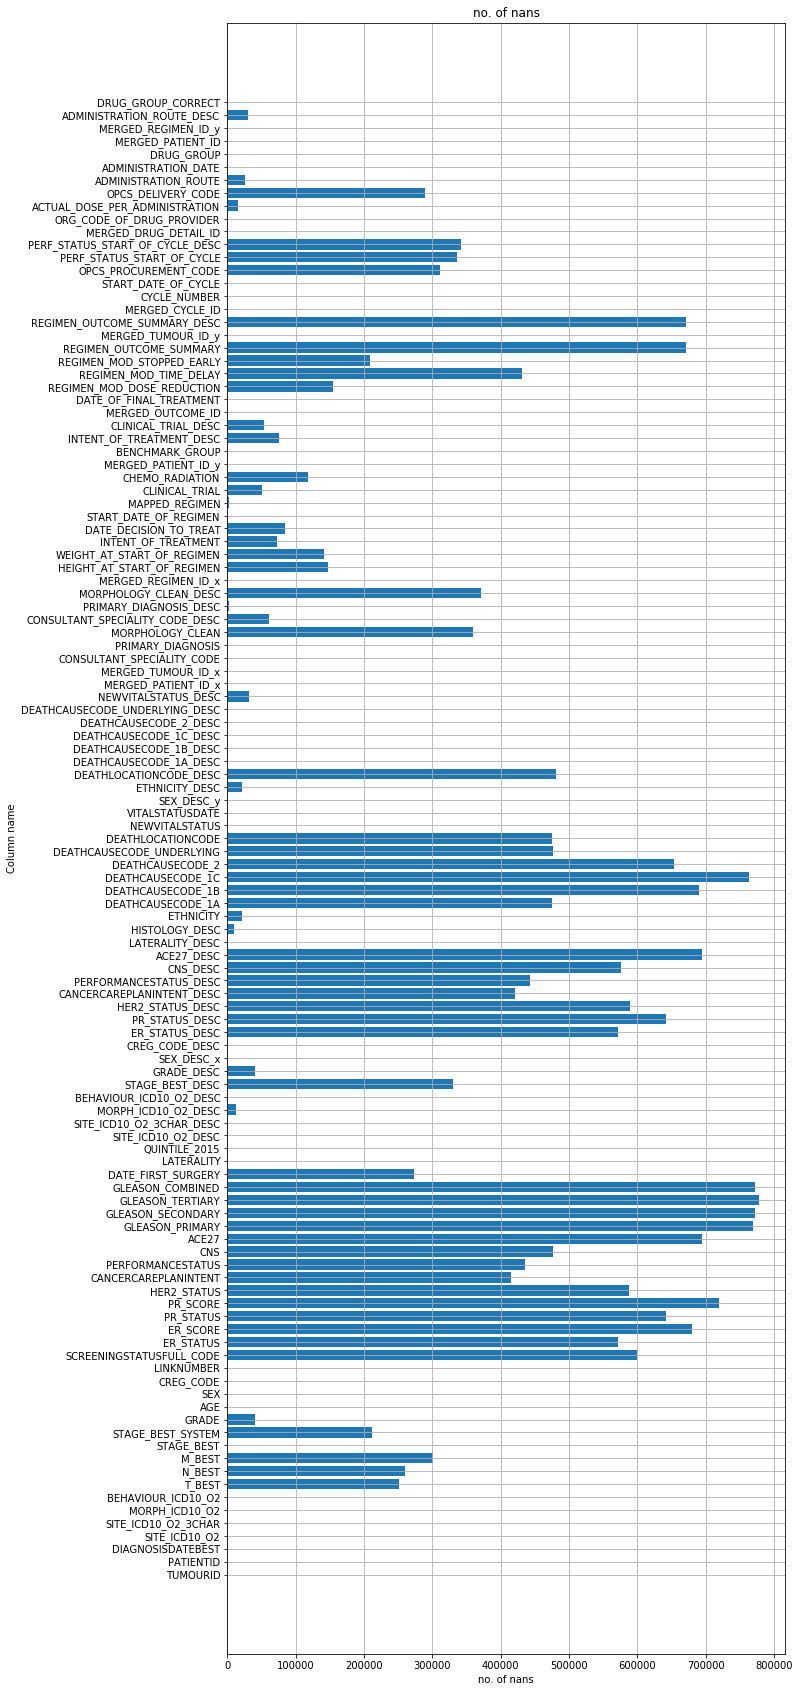

In [52]:
nans = df_full_patient_pathways.isna().sum()

plt.figure(figsize=(10,30))
plt.barh(nans.keys(),nans.values)
plt.grid(True)
plt.xlabel('no. of nans')
plt.ylabel('Column name')
plt.title('no. of nans')
plt.show()

More nans than bingo night!